In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sts

#to show all cols in df
from IPython.display import display
pd.options.display.max_columns = None

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import requests
import re
import plotly.plotly as py
import cufflinks as cf

import warnings
warnings.simplefilter('ignore')

init_notebook_mode(connected=True)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

import seaborn as sns
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [69]:
data = pd.read_csv('data/Kobe.csv')

In [70]:
target = 'shot_made_flag'

In [71]:
#Оставляем данные только с известным таргетом для возможности проведения оценки в дальнейшем
df = data[data[target].notnull()]

Приступим к генерации новых фич для датасета

В первую очередь, обработаем даты

In [5]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [72]:
df['game_date'] = pd.to_datetime(df['game_date'])

In [73]:
df['day_of_week'] = df['game_date'].apply(lambda x: x.strftime('%w'))
df['year'] = df['game_date'].apply(lambda x: x.strftime('%Y'))
df['month'] = df['game_date'].apply(lambda x: x.strftime('%m'))

In [74]:
df['secondsFromPeriodEnd']   = 60*df['minutes_remaining']+df['seconds_remaining']
df['secondsFromPeriodStart'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['secondsFromGameStart']   = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['secondsFromPeriodStart']

Обработаем категориальные и текстовые данные

In [75]:
df['combined_shot_type'].unique()

array(['Jump Shot', 'Dunk', 'Layup', 'Tip Shot', 'Hook Shot', 'Bank Shot'],
      dtype=object)

In [76]:
lst_to_dum = ['opponent','shot_type','combined_shot_type']
for x in lst_to_dum:
    df = pd.concat([df, pd.get_dummies(df[x], prefix=x)], axis=1)
    df = df.drop(x, axis=1)

In [77]:
lst_actiion_types = df['action_type'].unique()
lst_actiion_types = [x.split()[0] for x in lst_actiion_types]
import operator
unique, counts = np.unique(lst_actiion_types, return_counts=True)
x = dict(sorted(dict(zip(unique, counts)).items(), key=operator.itemgetter(1),reverse=True))
for z in list(x.keys())[:6]:
    df['has_'+z] = df['action_type'].apply(lambda x: 1 if z in x else 0)

Обработаем данные о положении

In [78]:
#переход к полярным координатам
df['dist'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)

loc_x_zero = df['loc_x'] == 0
df['angle'] = np.array([0]*len(df))
df['angle'][~loc_x_zero] = np.arctan(df['loc_y'][~loc_x_zero] / df['loc_x'][~loc_x_zero])
df['angle'][loc_x_zero] = np.pi / 2 

Избавимся от ненужных переменных

In [79]:
lst_to_drop = ['shot_zone_area','shot_zone_basic','shot_zone_range','team_id','team_name','game_date','matchup','shot_id', 'season','seconds_remaining','shot_distance', 'action_type','game_event_id','game_id','lat','loc_x','loc_y','lon','minutes_remaining']

In [80]:
df.drop(lst_to_drop,axis=1,inplace=True)

In [81]:
df.head()

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,shot_type_2PT Field Goal,shot_type_3PT Field Goal,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
1,1,0,0.0,2,2000,10,622,98,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,157.000000,-0.000000
2,1,0,1.0,2,2000,10,465,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,168.600119,-0.928481
3,1,0,0.0,2,2000,10,412,308,308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,222.865430,0.903063
4,2,0,1.0,2,2000,10,379,341,1061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0.000000,1.570796
5,3,0,0.0,2,2000,10,572,148,1588,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,145.416643,0.075717


In [82]:
df.dtypes

period                            int64
playoffs                          int64
shot_made_flag                  float64
day_of_week                      object
year                             object
month                            object
secondsFromPeriodEnd              int64
secondsFromPeriodStart            int64
secondsFromGameStart              int64
opponent_ATL                      uint8
opponent_BKN                      uint8
opponent_BOS                      uint8
opponent_CHA                      uint8
opponent_CHI                      uint8
opponent_CLE                      uint8
opponent_DAL                      uint8
opponent_DEN                      uint8
opponent_DET                      uint8
opponent_GSW                      uint8
opponent_HOU                      uint8
opponent_IND                      uint8
opponent_LAC                      uint8
opponent_MEM                      uint8
opponent_MIA                      uint8
opponent_MIL                      uint8


In [83]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

In [84]:
detect_outliers(df['dist']).sum()

95

95 значений в датасете - потенциальные выбросы в данных по признаку 'dist'

In [85]:
df.shape[0]

25697

In [86]:
df = df[~detect_outliers(df['dist'])]

In [87]:
df.shape[0]

25602

Избавились от выбросов в данных

In [88]:
detect_outliers(df['angle']).sum()

0

In [89]:
df['year'] = df['year'].astype('int')
df['month'] = df['month'].astype('int')
df['day_of_week'] = df['day_of_week'].astype('int')

In [90]:
df.describe()

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,shot_type_2PT Field Goal,shot_type_3PT Field Goal,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
count,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.00000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000,25602.000000
mean,2.522459,0.146200,0.447778,2.696742,2006.126240,5.572729,322.690884,397.309116,1487.557535,0.017069,0.001758,0.030466,0.01953,0.020037,0.020037,0.040114,0.052652,0.022772,0.044567,0.054488,0.024217,0.041833,0.033865,0.020194,0.019764,0.047535,0.016366,0.018475,0.011210,0.022069,0.021834,0.023592,0.023475,0.059566,0.050113,0.054371,0.063823,0.026912,0.021639,0.048160,0.007929,0.019569,0.792282,0.207718,0.004687,0.041247,0.004961,0.766151,0.177017,0.005937,0.085189,0.036755,0.051754,0.750801,0.000547,0.019491,137.240441,0.324522
std,1.152142,0.353313,0.497275,1.968538,4.827682,4.153716,207.788979,207.788979,851.686635,0.129531,0.041889,0.171870,0.13838,0.140131,0.140131,0.196231,0.223342,0.149178,0.206355,0.226982,0.153725,0.200211,0.180884,0.140665,0.139191,0.212785,0.126881,0.134664,0.105285,0.146910,0.146145,0.151777,0.151409,0.236685,0.218183,0.226752,0.244442,0.161829,0.145504,0.214109,0.088693,0.138516,0.405682,0.405682,0.068303,0.198864,0.070258,0.423285,0.381691,0.076825,0.279168,0.188163,0.221534,0.432558,0.023379,0.138244,92.054447,1.002574
min,1.000000,0.000000,0.000000,0.000000,1996.000000,1.000000,0.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.566980
25%,1.000000,0.000000,0.000000,1.000000,2002.000000,2.000000,143.000000,221.000000,704.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,53.478958,-0.610726
50%,3.000000,0.000000,0.000000,3.000000,2006.000000,4.000000,305.000000,415.000000,1504.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

### Baseline

Попробуем построить первую базовую модель без какой-то дополнительной обработки и настройки

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Данные достаточно сбалансированы

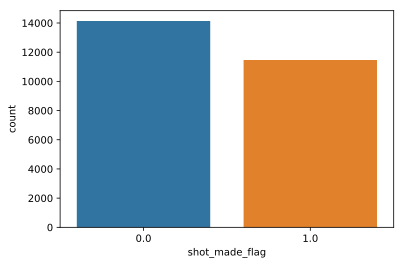

In [92]:
sns.countplot('shot_made_flag',data=df);

In [93]:
y = df['shot_made_flag'].copy()
x = df.drop(['shot_made_flag'],axis=1)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.3, random_state=42)

In [95]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [96]:
xgb = xgboost.XGBClassifier(max_depth=4, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.73
Test:  0.66


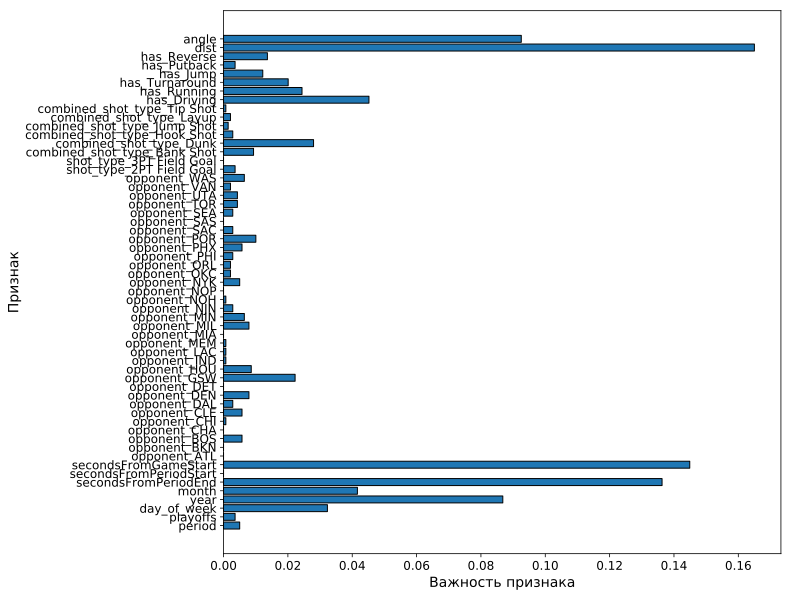

In [103]:
plt.rcParams['figure.figsize'] = (10, 10)

def plot_feature_importances(model):
    n_features = len(x.columns)
    plt.barh(range(n_features),model.feature_importances_,ec="black",align='center')
    plt.yticks(np.arange(n_features),x.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
 

plt.tight_layout()
plot_feature_importances(xgb)

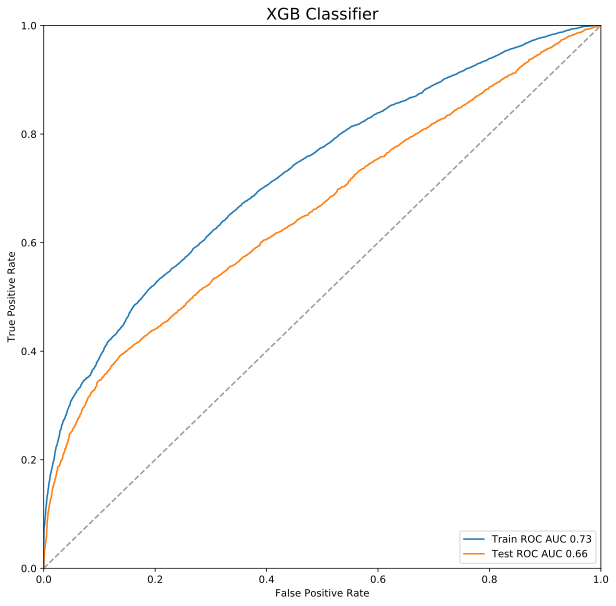

In [98]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

Можем видеть,  что качество модели невысокое. Оценка на тренирововочном наборе сильно выше, чем на тестовом. Что говорит о переобучении. Также можем видеть, что в модели сейчас есть много не значимых пизнаков (в основном это названия оппонентов, с которым играл Коби). Все значимые переменные оказались ожидаемыми, про них мы делали предположение еще в первичном анализе данных. Попробуем выполнить отбор признаком и применим другие техники обработки днных, чтобы добиться лучшего качества.

In [99]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

# to make this notebook's output stable across runs
np.random.seed(42)

Попробуем применить модель логистической регрессии для оценки необходимости включения в модели различных атрибутов

In [100]:
df.columns

Index(['period', 'playoffs', 'shot_made_flag', 'day_of_week', 'year', 'month',
       'secondsFromPeriodEnd', 'secondsFromPeriodStart',
       'secondsFromGameStart', 'opponent_ATL', 'opponent_BKN', 'opponent_BOS',
       'opponent_CHA', 'opponent_CHI', 'opponent_CLE', 'opponent_DAL',
       'opponent_DEN', 'opponent_DET', 'opponent_GSW', 'opponent_HOU',
       'opponent_IND', 'opponent_LAC', 'opponent_MEM', 'opponent_MIA',
       'opponent_MIL', 'opponent_MIN', 'opponent_NJN', 'opponent_NOH',
       'opponent_NOP', 'opponent_NYK', 'opponent_OKC', 'opponent_ORL',
       'opponent_PHI', 'opponent_PHX', 'opponent_POR', 'opponent_SAC',
       'opponent_SAS', 'opponent_SEA', 'opponent_TOR', 'opponent_UTA',
       'opponent_VAN', 'opponent_WAS', 'shot_type_2PT Field Goal',
       'shot_type_3PT Field Goal', 'combined_shot_type_Bank Shot',
       'combined_shot_type_Dunk', 'combined_shot_type_Hook Shot',
       'combined_shot_type_Jump Shot', 'combined_shot_type_Layup',
       'combined_shot

In [147]:
d = df.copy()
d.rename(columns={'shot_type_2PT Field Goal' : 'twoPT_Field_Goal',
       'shot_type_3PT Field Goal' : 'threePT_Field_Goal', 'combined_shot_type_Bank Shot' : 'Bank_Shot',
       'combined_shot_type_Hook Shot' : 'Hook_Shot',
       'combined_shot_type_Jump Shot' : 'Jump_Shot', 
       'combined_shot_type_Tip Shot' : 'Tip_Shot'},inplace=True)

In [148]:
d.head(2)

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,twoPT_Field_Goal,threePT_Field_Goal,Bank_Shot,combined_shot_type_Dunk,Hook_Shot,Jump_Shot,combined_shot_type_Layup,Tip_Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
1,1,0,0.0,2,2000,10,622,98,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,157.000000,-0.000000
2,1,0,1.0,2,2000,10,465,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,168.600119,-0.928481


In [149]:
def get_formula(_cols):
    return 'shot_made_flag ~ ' + " + ".join(_cols)

In [150]:
_iteration_cols = d.columns.drop('shot_made_flag')

In [151]:
f = get_formula(_iteration_cols)
f

'shot_made_flag ~ period + playoffs + day_of_week + year + month + secondsFromPeriodEnd + secondsFromPeriodStart + secondsFromGameStart + opponent_ATL + opponent_BKN + opponent_BOS + opponent_CHA + opponent_CHI + opponent_CLE + opponent_DAL + opponent_DEN + opponent_DET + opponent_GSW + opponent_HOU + opponent_IND + opponent_LAC + opponent_MEM + opponent_MIA + opponent_MIL + opponent_MIN + opponent_NJN + opponent_NOH + opponent_NOP + opponent_NYK + opponent_OKC + opponent_ORL + opponent_PHI + opponent_PHX + opponent_POR + opponent_SAC + opponent_SAS + opponent_SEA + opponent_TOR + opponent_UTA + opponent_VAN + opponent_WAS + twoPT_Field_Goal + threePT_Field_Goal + Bank_Shot + combined_shot_type_Dunk + Hook_Shot + Jump_Shot + combined_shot_type_Layup + Tip_Shot + has_Driving + has_Running + has_Turnaround + has_Jump + has_Putback + has_Reverse + dist + angle'

In [153]:
#f = 'shot_made_flag ~ period + playoffs + day_of_week + year + month + secondsFromPeriodEnd + secondsFromPeriodStart + secondsFromGameStart + opponent_ATL + opponent_BKN + opponent_BOS + opponent_CHA + opponent_CHI + opponent_CLE + opponent_DAL + opponent_DEN + opponent_DET + opponent_GSW + opponent_HOU + opponent_IND + opponent_LAC + opponent_MEM + opponent_MIA + opponent_MIL + opponent_MIN + opponent_NJN + opponent_NOH + opponent_NOP + opponent_NYK + opponent_OKC + opponent_ORL + opponent_PHI + opponent_PHX + opponent_POR + opponent_SAC + opponent_SAS + opponent_SEA + opponent_TOR + opponent_UTA + opponent_VAN + opponent_WAS + shot_type_2PT_Field_Goal + shot_type_3PT_Field_Goal + combined_shot_type_Bank_Shot + combined_shot_type_Dunk + combined_shot_type_Hook_Shot + combined_shot_type_Jump_Shot + combined_shot_type_Layup + combined_shot_type_Tip_Shot + has_Driving + has_Running + has_Turnaround + has_Jump + has_Putback + has_Reverse + dist + angle'
logitfit = smf.logit(formula = str(f), data = d).fit()

         Current function value: 0.629023
         Iterations: 35


In [156]:
est_res = logitfit.summary()

Выведем также odds ratio. В логистической регрессии  оно используется для интерпретации влияния коэффициентов. OR - это отношение успеха события к его неуспеху (или наоборот). Оно используется, когда нам необходимо оценить постоянное влияния параметра на модель. То есть, например, если бы мы использовали обычные вероятности, то изменения предиктора X давало нам каждый раз бы разные значения вероятности. OR будет постоянным

In [168]:

print(est_res)
print ("Odds Ratios")
print("======================")
print(np.exp(logitfit.params))

                           Logit Regression Results                           
Dep. Variable:         shot_made_flag   No. Observations:                25602
Model:                          Logit   Df Residuals:                    25548
Method:                           MLE   Df Model:                           53
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.08530
Time:                        06:13:14   Log-Likelihood:                -16104.
converged:                      False   LL-Null:                       -17606.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4270        nan        nan        nan         nan         nan
period                       0.1419      0.176      0.806      0.420      -0.203       0.

Можем видеть, что p-value практически всех переменных высокие, однако odd ratio многих из них высокое. Это предпологает, что некоторые из них все же имеют влияние на успешность броска.

Например, combined_shot_type_Dunk имеет OR 8.49, это говорит о том, что увеличение combined_shot_type_Dunk на 1 дает нам увеличение в 749% в odds ratio успешности попадания.

In [169]:
params = logitfit.params
conf = logitfit.conf_int()
conf["OR"] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
print(np.exp(conf))

                          Lower CI  Upper CI            OR
Intercept                      NaN       NaN  1.532713e+00
period                    0.816069  1.627454  1.152438e+00
playoffs                  0.913935  1.071220  9.894572e-01
day_of_week               0.987232  1.014225  1.000637e+00
year                      0.999667  1.011421  1.005527e+00
month                     0.991739  1.004508  9.981030e-01
secondsFromPeriodEnd      0.000000       inf  9.872426e-01
secondsFromPeriodStart    0.000000       inf  9.872524e-01
secondsFromGameStart      0.999245  1.000217  9.997309e-01
opponent_ATL              0.000000       inf  4.524224e+05
opponent_BKN              0.000000       inf  2.979185e+05
opponent_BOS              0.000000       inf  4.328669e+05
opponent_CHA              0.000000       inf  4.752886e+05
opponent_CHI              0.000000       inf  4.629140e+05
opponent_CLE              0.000000       inf  4.689824e+05
opponent_DAL              0.000000       inf  4.808032e+

Можем видеть, например, что бросок в прыжке (has_Jump  OR 8.61) имеет odds ratio практически в 4 раза большее, чем прыжок с разврота (has_Reverse  OR 2.14).То есть прыжок повышает верояность попадания.

Давайте попробуем убрать Hook Shot Jump Shot и всех оппонентов, так как у них большие p-value, а Hook Shot Jump Shot могут коррелировать с has_Jump  и также имеют большие p value 

In [198]:
f1 = 'shot_made_flag ~ period + playoffs + day_of_week + year + month + secondsFromPeriodEnd + secondsFromPeriodStart + secondsFromGameStart + twoPT_Field_Goal + threePT_Field_Goal + Bank_Shot + combined_shot_type_Dunk  + combined_shot_type_Layup + Tip_Shot + has_Driving + has_Running + has_Turnaround + has_Jump + has_Putback + has_Reverse + dist + angle'

In [195]:
#f = 'shot_made_flag ~ period + playoffs + day_of_week + year + month + secondsFromPeriodEnd + secondsFromPeriodStart + secondsFromGameStart + opponent_ATL + opponent_BKN + opponent_BOS + opponent_CHA + opponent_CHI + opponent_CLE + opponent_DAL + opponent_DEN + opponent_DET + opponent_GSW + opponent_HOU + opponent_IND + opponent_LAC + opponent_MEM + opponent_MIA + opponent_MIL + opponent_MIN + opponent_NJN + opponent_NOH + opponent_NOP + opponent_NYK + opponent_OKC + opponent_ORL + opponent_PHI + opponent_PHX + opponent_POR + opponent_SAC + opponent_SAS + opponent_SEA + opponent_TOR + opponent_UTA + opponent_VAN + opponent_WAS + shot_type_2PT_Field_Goal + shot_type_3PT_Field_Goal + combined_shot_type_Bank_Shot + combined_shot_type_Dunk + combined_shot_type_Hook_Shot + combined_shot_type_Jump_Shot + combined_shot_type_Layup + combined_shot_type_Tip_Shot + has_Driving + has_Running + has_Turnaround + has_Jump + has_Putback + has_Reverse + dist + angle'
logitfit = smf.logit(formula = str(f1), data = d).fit()

         Current function value: 0.629528
         Iterations: 35


In [196]:
est_res = logitfit.summary()

print(est_res)
print ("Odds Ratios")
print("======================")
print(np.exp(logitfit.params))

                           Logit Regression Results                           
Dep. Variable:         shot_made_flag   No. Observations:                25602
Model:                          Logit   Df Residuals:                    25581
Method:                           MLE   Df Model:                           20
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.08457
Time:                        07:09:55   Log-Likelihood:                -16117.
converged:                      False   LL-Null:                       -17606.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2134        nan        nan        nan         nan         nan
period                       0.1445      0.176      0.821      0.412      -0.200       0.

Пока что, можно предположить, что переменные оппонентов не сильно значимы для модели. Переменные, относящиеся к типу броска,  скорее всего , будут важными для модели. Переменную has Jump можно убрать, так как у нас уже есть похожая Jump Shoot.

In [207]:
df.corr()

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,shot_type_2PT Field Goal,shot_type_3PT Field Goal,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
period,1.000000,0.004072,-0.033507,0.009393,-0.019857,-0.017955,-0.048703,0.048703,0.969223,-0.014478,-0.006079,0.004829,0.001659,0.008463,-0.003876,0.003185,-0.003533,0.005547,-0.011028,0.006448,-0.005938,-0.010931,-0.009741,0.011060,0.003321,-0.013198,0.000826,0.001731,-0.016727,-0.013890,-0.004188,0.017073,-0.002015,0.009633,0.018131,-0.006020,0.005312,0.001891,0.003159,0.009945,0.000742,-0.008016,-0.085539,0.085539,-0.006798,-0.004214,-0.010304,0.021062,-0.019167,0.005554,-0.009288,0.007814,-0.019016,0.022204,-0.004806,-0.016604,0.054342,-0.014893
playoffs,0.004072,1.000000,-0.001119,-0.044812,-0.051469,-0.061636,0.009319,-0.009319,0.002335,-0.054530,-0.017364,0.082957,-0.058402,-0.059171,-0.059171,-0.044028,0.067778,0.005014,-0.089372,0.031685,-0.015566,-0.086463,-0.077473,-0.059406,-0.058758,0.024459,-0.001967,0.016294,-0.044060,-0.062162,0.097794,0.017260,0.003019,0.095777,0.022005,0.054846,0.157443,-0.065400,-0.061541,0.066473,-0.036994,-0.058461,0.014032,-0.014032,0.002357,-0.010222,-0.010334,0.005301,-0.000167,0.005436,0.004411,0.021990,-0.011835,0.010416,0.004508,-0.007960,-0.010125,-0.006913
shot_made_flag,-0.033507,-0.001119,1.000000,-0.000457,-0.019626,-0.004042,0.026000,-0.026000,-0.038954,0.001408,-0.004032,-0.012462,-0.003343,-0.004322,-0.002080,0.003656,0.005415,-0.001082,0.007646,-0.005762,-0.013603,0.006054,0.001640,-0.005306,-0.010483,-0.001087,-0.002240,0.001284,-0.008589,0.009093,-0.008228,-0.003860,0.000978,0.010003,0.009541,0.009247,-0.005356,0.002661,0.005361,-0.001141,0.004518,-0.005862,0.116229,-0.116229,0.047457,0.200320,0.012446,-0.199705,0.109415,-0.015400,0.201856,0.120495,0.072934,-0.206687,0.009176,0.071342,-0.192575,0.101493
day_of_week,0.009393,-0.044812,-0.000457,1.000000,0.000724,0.006796,0.004125,-0.004125,0.007492,-0.029945,0.002201,-0.023951,0.034074,-0.014929,-0.000344,-0.028471,0.007000,-0.013860,0.006444,-0.006378,-0.053307,0.062616,-0.001763,-0.025845,-0.005923,0.052320,-0.010311,0.020546,0.030538,-0.066677,-0.000201,-0.036323,0.018643,0.002470,0.007010,0.002287,0.035841,-0.002827,-0.075004,0.025478,0.005719,0.019473,-0.000671,0.000671,-0.005116,0.010301,-0.005503,0.006722,-0.009131,-0.008757,-0.011557,-0.006921,0.001685,0.004964,-0.009977,0.007654,0.007398,-0.016522
year,-0.019857,-0.051469,-0.019626,0.000724,1.000000,-0.016209,-0.026323,0.026323,-0.012314,0.028286,0.061872,0.052092,0.024784,-0.006742,0.014449,0.002241,0.050386,-0.011368,0.001959,-0.001822,-0.000172,-0.016860,0.066092,0.004069,-0.011735,-0.027706,-0.046481,0.090683,0.055698,0.012815,0.161629,0.009476,-0.036438,0.010580,-0.053881,-0.056904,-0.078125,-0.100044,0.005731,0.001222,-0.127955,0.020138,-0.099974,0.099974,0.053288,-0.082890,0.017731,0.090295,-0.060077,-0.048045,-0.051367,-0.076531,0.114964,0.049670,0.014962,0.017734,0.124808,-0.105850
month,-0.017955,-0.061636,-0.004042,0.006796,-0.016209,1.000000,0.011809,-0.011809,-0.020686,-0.008805,0.014419,0.002313,-0.032440,0.081481,-0.071591,0.012882,-0.011117,0.016333,0.030283,0.038573,-0.016155,-0.018243,0.020818,-0.011572,0.035821,-0.007381,0.021421,-0.020035,0.003629,-0.006887,-0.017898,0.020079,0.023837,-0.011737,-0.052661,-0.001171

Да, наши предположения подтверждаются, корреляция между Jump переменными 95%. Необходимо убрать одну из них.

In [208]:
col_op = [x for x in df.columns if 'opponent' in x]

In [217]:
x = df.drop(col_op,axis=1)
x_cor = x.corr()
mask = x_cor.apply(lambda x: abs(x) > 0.5,axis=0)
x_cor[mask]

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,shot_type_2PT Field Goal,shot_type_3PT Field Goal,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
period,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
playoffs,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_made_flag,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromPeriodEnd,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromPeriodStart,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromGameStart,0.969223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_type_2PT Field Goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.662355,NaN


Можем также видеть, что combined_shot_type_Layup достаточно сильно коррелирует с Jump Shoot. Таким образом, можно с уже большей уверенностью говорить, что Jump Shot стоит убрать

In [219]:
x_cor = df.corr()
mask = x_cor.apply(lambda x: abs(x) > 0.5,axis=0)
x_cor[mask]

,period,playoffs,shot_made_flag,day_of_week,year,month,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,opponent_ATL,opponent_BKN,opponent_BOS,opponent_CHA,opponent_CHI,opponent_CLE,opponent_DAL,opponent_DEN,opponent_DET,opponent_GSW,opponent_HOU,opponent_IND,opponent_LAC,opponent_MEM,opponent_MIA,opponent_MIL,opponent_MIN,opponent_NJN,opponent_NOH,opponent_NOP,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,shot_type_2PT Field Goal,shot_type_3PT Field Goal,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,has_Driving,has_Running,has_Turnaround,has_Jump,has_Putback,has_Reverse,dist,angle
period,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
playoffs,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shot_made_flag,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromPeriodEnd,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromPeriodStart,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
secondsFromGameStart,0.969223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
opponent_ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Переменные с оппонентами не коррелируют сильно ни с одной другой переменной

In [240]:
df = df.drop('combined_shot_type_Jump Shot', axis=1)

In [245]:

# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(x, y)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: %d


TypeError: unsupported operand type(s) for %: 'NoneType' and 'int'

In [246]:
fit.n_features_

3

In [247]:
fit.support_

array([False, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [248]:
fit.ranking_

array([19, 20,  1, 13, 17, 18, 16, 15, 22,  1,  1, 10,  8,  7,  2,  3,  5,
        9,  6, 12,  4, 21, 14, 23, 11])